# signac-flow minimal example (with HOOMD-blue)

## About

This notebook contains a minimal example for running a signac flow project from scratch.
The example demonstrates how to compare an ideal gas with a lennard jones fluid by calculating a p-V phase diagram.

## Author

Carl Simon Adorf

## Before you start

Before running this notebook, the first time, make sure to initialize the project directory!

    mkdir -p ~/tmp/projects/signac-flow-hoomd-blue
    cd ~/tmp/projects/signac-flow-hoomd-blue
    signac init FlowExampleProject
    
You can of course use a different project root directory or project name!

In [1]:
import signac
import flow
%cd ~/tmp/projects/signac-flow-hoomd-blue

import numpy as np
import hoomd_script as hoomd

init_context = True
if init_context:
    hoomd.context.initialize('--mode=gpu')
    init_context=False

from matplotlib import pyplot as plt
%matplotlib inline

/home/csadorf/tmp/projects/signac-flow-hoomd-blue


We define the project *work flow* by specializing a `flow.FlowProject`.

By implementing the `classify()` function we are able to label our *jobs* and get a good overview of the project *status*.

The `next_operation` function helps to automate our workflow by identifying the next required operation for each *job*.

In [2]:
class MyProject(flow.FlowProject):
    
    def classify(self, job):
        yield 'init'
        if 'V' in job.document:
            yield 'estimated'
        if job.isfile('dump.log'):
            yield 'dumped'
    
    def next_operation(self, job):
        labels = set(self.classify(job))
        if 'V' not in job.document:
            return 'estimate'
        if not 'dumped' in labels:
            return 'run'

project = MyProject()

Next, we start implementing the actual simulation protocol.
In this case we run a Lennard-Jones molecular dynamics simulation with HOOMD-blue.

In [3]:
def run_lj(N, sigma, seed, T, tau, p, tauP, steps, r_cut):
    system = hoomd.init.create_random(N=N, seed=seed, phi_p=0.1)
    lj = hoomd.pair.lj(r_cut=r_cut)
    lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=sigma)
    hoomd.integrate.mode_standard(dt=0.005)
    hoomd.integrate.npt(group=hoomd.group.all(), T=T, tau=tau, P=p, tauP=tauP)
    hoomd.analyze.log('dump.log', ['volume'], 100, phase=0)
    hoomd.run(steps)

We create a `Operations` class to define our *operations*, which allows to more easily access functions by name.

In [4]:
class Operations:
    
    def estimate(self, job):
        sp = job.statepoint()
        job.document['V'] = sp['N'] * sp['T'] / sp['p']

    def run(self, job):
        if hoomd.init.is_initialized():
            hoomd.init.reset()
        with job:
            run_lj(steps=10000, ** job.statepoint())

    def get_volume(self, job):
        log = np.genfromtxt(job.fn('dump.log'), names=True)
        N = len(log)
        return log[int(0.5 * N):]['volume'].mean(axis=0)

Before execution, we need to initialize the data space!

In [5]:
for p in np.linspace(0.5, 5.0, 10):
    sp = dict(N=1000, sigma=1.0, seed=42, T=1.0, p=p, tau=1.0, tauP=1.0, r_cut=2.5)
    project.open_job(sp).init()

The `print_status()` function allows to get a quick overview of our project's *status*:

In [6]:
project.print_status(detailed=True, parameters=['p'])


Status project 'FlowExampleProject':
Total # of jobs: 10
label    progress
-------  --------------------------------------------------
init     |########################################| 100.00%

Detailed view:
job_id                              p  status    next_operation    labels
--------------------------------  ---  --------  ----------------  --------
36fbee777a85affc5dca3734ba625d9b  2    unknown   estimate          init
7e18c34faf1e4a47fa445d6f8bb81445  5    unknown   estimate          init
9d12a5371558037b8b34a4af73a688a9  0.5  unknown   estimate          init
758f428090a22bb643e3acf3108267dc  2.5  unknown   estimate          init
5d5955021726754fa5c4ce589090ec66  1.5  unknown   estimate          init
6c4c7b2fdb7cff84749e26a6e299c866  1    unknown   estimate          init
c471f8e5a7cceefe6ec499b7beb2040c  3.5  unknown   estimate          init
604300115793fabee21c2cb576f59fe2  4    unknown   estimate          init
48714a741353843083b7b868241afd4b  4.5  unknown   estimate     

Generate output...


The next cell will attempt to execute all operations by cycling through jobs and operations until no *next operations* are defined anymore.

We limit the max. number of cycles to prevent accidental infinite loops.

In [7]:
for i in range(10):
    for job in project.find_jobs():
        next_op = project.next_operation(job)
        while next_op is not None:
            print(job, next_op)
            getattr(Operations(), next_op)(job)
            # Make sure that the next operation is actually different to not get stuck.
            old_op = next_op
            next_op = project.next_operation(job)
            assert old_op != next_op

36fbee777a85affc5dca3734ba625d9b estimate
36fbee777a85affc5dca3734ba625d9b run
7e18c34faf1e4a47fa445d6f8bb81445 estimate
7e18c34faf1e4a47fa445d6f8bb81445 run
9d12a5371558037b8b34a4af73a688a9 estimate
9d12a5371558037b8b34a4af73a688a9 run
758f428090a22bb643e3acf3108267dc estimate
758f428090a22bb643e3acf3108267dc run
5d5955021726754fa5c4ce589090ec66 estimate
5d5955021726754fa5c4ce589090ec66 run
6c4c7b2fdb7cff84749e26a6e299c866 estimate
6c4c7b2fdb7cff84749e26a6e299c866 run
c471f8e5a7cceefe6ec499b7beb2040c estimate
c471f8e5a7cceefe6ec499b7beb2040c run
604300115793fabee21c2cb576f59fe2 estimate
604300115793fabee21c2cb576f59fe2 run
48714a741353843083b7b868241afd4b estimate
48714a741353843083b7b868241afd4b run
d775bb92abd3e31d482d5de1a94dbca3 estimate
d775bb92abd3e31d482d5de1a94dbca3 run


Let's double check the project status.

In [8]:
project.print_status()


Status project 'FlowExampleProject':
Total # of jobs: 10
label      progress
---------  --------------------------------------------------
init       |########################################| 100.00%
estimated  |########################################| 100.00%
dumped     |########################################| 100.00%


Generate output...


After running all operations we can make a brief examination of the collected data.

In [9]:
for job in project.find_jobs():
    print(job.statepoint()['p'], Operations().get_volume(job), job.document.get('V'))

2.0 1230.11330076 500.0
5.0 1090.81659918 200.0
0.5 1470.68172364 2000.0
2.5 1195.5182813 400.0
1.5 1280.46656496 666.6666666666666
1.0 1355.36461422 1000.0
3.5 1144.38381708 285.7142857142857
4.0 1118.46959234 250.0
4.5 1104.9108105 222.22222222222223
3.0 1166.59876704 333.3333333333333


For a better presentation of the results we need to aggregate all results and sort them by pressure.

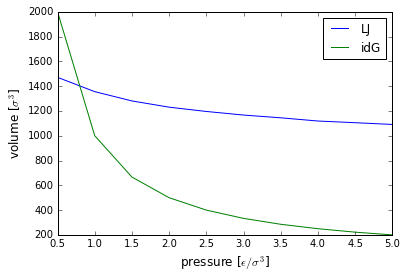

In [10]:
V = dict()
V_idg = dict()

for job in project.find_jobs():
    V[job.statepoint()['p']] = Operations().get_volume(job)
    V_idg[job.statepoint()['p']] = job.document['V']
    
p = sorted(V.keys())
V = [V[p_] for p_ in p]
V_idg = [V_idg[p_] for p_ in p]

plt.plot(p, V, label='LJ')
plt.plot(p, V_idg, label='idG')
plt.xlabel(r'pressure [$\epsilon / \sigma^3$]')
plt.ylabel(r'volume [$\sigma^3$]')
plt.legend()

As a a final step, we ca generate a index of our project data:

In [11]:
import glotzformats as gf

formats = {
    '.*\.log': gf.formats.AnalysisLogFile
}
for doc in project.index(formats):
    print(doc)

{'filename': '36fbee777a85affc5dca3734ba625d9b/dump.log', 'root': '/home/csadorf/tmp/projects/signac-flow-hoomd-blue/workspace', 'format': "<class 'glotzformats.formats.AnalysisLogFile'>", '_id': '61bf4c78a2dd4064a38c83e910db61a9', 'signac_id': '36fbee777a85affc5dca3734ba625d9b', 'statepoint': {'N': 1000, 'T': 1.0, 'p': 2.0, 'seed': 42, 'r_cut': 2.5, 'sigma': 1.0, 'tauP': 1.0, 'tau': 1.0}}
{'V': 500.0, '_id': '36fbee777a85affc5dca3734ba625d9b', 'format': None, 'signac_id': '36fbee777a85affc5dca3734ba625d9b', 'statepoint': {'N': 1000, 'T': 1.0, 'p': 2.0, 'seed': 42, 'r_cut': 2.5, 'sigma': 1.0, 'tauP': 1.0, 'tau': 1.0}}
{'filename': '7e18c34faf1e4a47fa445d6f8bb81445/dump.log', 'root': '/home/csadorf/tmp/projects/signac-flow-hoomd-blue/workspace', 'format': "<class 'glotzformats.formats.AnalysisLogFile'>", '_id': 'e3cdd12157ac42a06226851296ab6304', 'signac_id': '7e18c34faf1e4a47fa445d6f8bb81445', 'statepoint': {'N': 1000, 'T': 1.0, 'p': 5.0, 'seed': 42, 'r_cut': 2.5, 'sigma': 1.0, 'tauP':